In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
data = pd.read_csv('data/ratings.csv')
data.drop('timestamp', axis=1, inplace=True)
data = data.dropna()
data['movieId'] = data['movieId'].astype('int64')
print(len(data))
data.head(2)

26024289


,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5


In [3]:
movies_data = pd.read_csv('data/movies_metadata.csv')
movies_data = movies_data.rename(columns={"id": "movieId"})
print(len(movies_data))
movies_data.head(2)

45466


C:\Users\ksn\AppData\Local\Temp\ipykernel_11580\1554198658.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_data = pd.read_csv('data/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [4]:
movies = movies_data.copy()

for i in movies_data.index:
    if re.findall('-', movies_data.iloc[i]['movieId']):
        movies.drop(i, inplace=True)

movies['movieId'] = movies['movieId'].astype('int64')

In [5]:
my_ratings = pd.read_csv('ratings.csv')
print(len(my_ratings))
my_ratings = my_ratings.rename(columns={"Const": "imdb_id", "Your Rating": "rating"})
my_ratings.head(2)

128


,imdb_id,rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt1014759,9,2023-12-21,Alice in Wonderland,https://www.imdb.com/title/tt1014759/,movie,6.4,108,2010,"Adventure, Family, Fantasy, Mystery",434961,2010-02-25,Tim Burton
1,tt0103639,9,2023-12-14,Aladdin,https://www.imdb.com/title/tt0103639/,movie,8.0,90,1992,"Animation, Adventure, Comedy, Family, Fantasy,...",455789,1992-11-08,"Ron Clements, John Musker"


In [6]:
my = my_ratings[['imdb_id', 'rating']].copy()
my['userId'] = 400000
ids = movies[['movieId', 'imdb_id']]
my = my.merge(ids, how='left', on='imdb_id')
my.drop('imdb_id', axis=1, inplace=True)
my.index = my['movieId']
my.head(2)

,rating,userId,movieId
movieId,,,
12155.0,9,400000,12155.0
812.0,9,400000,812.0


delete movies from the data that are not in the table 'movies'

In [7]:
delta = set(data['movieId']) - set(movies['movieId'])
data_train = data.loc[~data['movieId'].isin(delta)]
len(data_train)

11436568

In [8]:
genres = []

for i in range(len(movies)):
    genres.extend(list(map(lambda x: x[9:], re.findall("'name': '\w*", movies.iloc[i]['genres']))))

colms = list(set(genres))

df_genres = pd.DataFrame(columns=colms)
df_genres['movieId'] = movies['movieId']
df_genres = df_genres.fillna(0)
df_genres.index = df_genres['movieId']
df_genres.drop('movieId', axis=1, inplace=True)

for i in df_genres.index:
    genres = list(map(lambda x: x[9:], re.findall("'name': '\w*", str(movies.loc[movies['movieId'] == i]['genres']))))
    for j in genres:
        df_genres.at[i, j] = 1

sum_col = [sum(df_genres[i]) for i in df_genres.columns]

for i in df_genres.columns:
    if sum(df_genres[i]) < np.percentile(np.array(sum_col), 10):
        try:
            df_genres.drop(i, axis=1, inplace=True)
        except KeyError:
            pass

df_genres.head(3)

,Action,TV,Romance,Science,Music,Western,Family,Horror,Crime,Comedy,Documentary,Thriller,Fantasy,Adventure,Animation,Drama,Mystery,War
movieId,,,,,,,,,,,,,,,,,,
862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8844,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15602,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


limit by years

In [9]:
max_year = 2222
min_year = 1930

movieId = []
year = []

for i in movies['movieId']:
    movieId.append(i)
    try:
        year.append(int(re.findall('[0-9]{4}-', str(movies.loc[movies['movieId'] == i]['release_date']))[0][0:4]))
    except IndexError:
        year.append(9999)

df_year = pd.DataFrame({'movieId': movieId, 'year': year})
df_year = df_year.loc[(df_year['year'] < max_year)&(df_year['year'] > min_year)]

data_train = data_train.loc[data_train['movieId'].isin(df_year['movieId'])]
my = my.loc[my['movieId'].isin(df_year['movieId'])]
len(data_train)

11170809

### reducing amount of data

In [10]:
popularity_movie = data_train.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)
popularity_movie['rating_rank'] = popularity_movie['rating'].rank()
popularity_movie.drop('rating', axis=1, inplace=True)
popularity_movie.head(3)

,movieId,rating_rank
250,318,7349.0
230,296,7348.0
440,593,7347.0


In [11]:
data_train = pd.merge(data_train, popularity_movie, how='left', on='movieId')

In [12]:
user_sum_rating = data_train.groupby('userId')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_sum_rating.head(3)

,userId,rating_rank
0,8659,15530502.5
1,45811,15090942.0
2,179792,14401254.0


In [13]:
user_count_rating = data_train.groupby('userId')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_count_rating.head(3)

,userId,rating_rank
0,45811,3507
1,8659,2966
2,179792,2527


In [14]:
user_rating = pd.merge(user_sum_rating, user_count_rating, how='left', on='userId')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,userId,rating_rank
0,8659,5236.177512
1,45811,4303.091531
2,179792,5698.952909


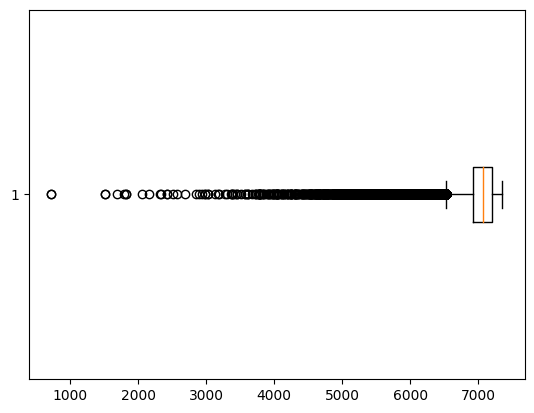

In [15]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

selected interquartile range 

Q1=6748.7190923317685, Q3=7072.555555555556


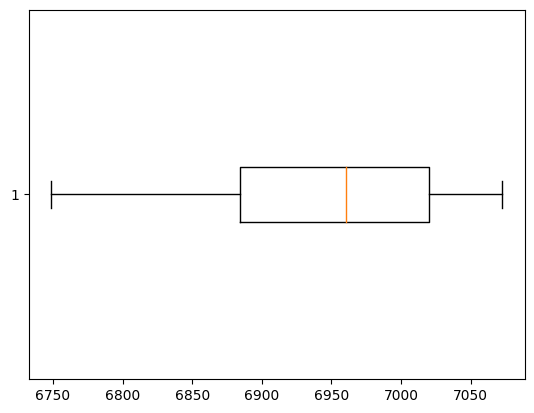

In [16]:
Q1 = user_rating['rating_rank'].quantile(0.1)
Q3 = user_rating['rating_rank'].quantile(0.5)
print(f'Q1={Q1}, Q3={Q3}')
user_rating_iqr = user_rating.loc[(user_rating['rating_rank'] < Q3) & (user_rating['rating_rank'] > Q1)]
user_list = user_rating_iqr['userId'].tolist()
plt.boxplot(user_rating_iqr['rating_rank'], vert=False)
plt.show()

In [17]:
data_train = data_train.loc[data_train['userId'].isin(user_list)]
data_train.drop('rating_rank', axis=1, inplace=True)
data_train = pd.concat([data_train, my], ignore_index=True)
len(data_train)

5831537

In [18]:
import implicit
from scipy.sparse import csr_matrix

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=100,
                                        regularization=0.05, 
                                        alpha=2.0,
                                        iterations=20,
                                        random_state=38)

# train the model on a sparse matrix of user/item/confidence weights
user_item_matrix = pd.pivot_table(data_train,
                                  index='userId', columns='movieId',
                                  values='rating',
                                  fill_value=0)

# scipy resets indexes
idALS_movieId = dict((i, j) for i, j in enumerate(user_item_matrix.columns))

user_item_matrix = user_item_matrix.astype(float)
user_item_matrix_csr = csr_matrix(user_item_matrix).tocsr()

model.fit(user_item_matrix_csr)

C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Python311\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.17s/it]


In [19]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
#user_item_matrix_csr = bm25_weight(user_item_matrix_csr, K1=100, B=0.8)

In [20]:
id_score = model.recommend(-1, user_item_matrix_csr[-1], N=250, filter_already_liked_items=True)
moviesId = [idALS_movieId[i] for i in id_score[0]]
ALScore = dict((i, j) for i, j in zip(moviesId, id_score[1]))

In [58]:
my_genres = df_genres[df_genres.index.isin(my.index)].mean().values

def rec_final(rec):
    name = []
    date = []
    url = []
    als_score = []
    score_imdb = []
    corr = []

    for i in rec:
        if i not in my.index:
            name.append(movies.loc[movies['movieId'] == i]['original_title'].values[0])
            date.append(movies.loc[movies['movieId'] == i]['release_date'].values[0])
            url.append('https://www.imdb.com/title/' + str(movies.loc[movies['movieId'] == i]['imdb_id'].values[0]))
            if type(rec) == list:
                als_score.append(ALScore[i])
            score_imdb.append(movies.loc[movies['movieId'] == i]['vote_average'].values[0])
            corr.append(0)
            if df_genres.loc[int(i)].sum().any() != 0:
                corr[-1] = (np.corrcoef(my_genres, df_genres.loc[int(i)])[0, 1])

    df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'score imdb': score_imdb, 'correlation': corr})
    df['rank'] = df['score imdb'].rank() + df['correlation'].rank()
    df = df.sort_values('rank', ascending=False)
    if type(rec) == list:
        df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'ALS score': als_score, 'score imdb': score_imdb, 'correlation': corr})
        df['rank'] = df['score imdb'].rank() + df['ALS score'].rank() + df['correlation'].rank()
        df = df.sort_values('rank', ascending=False)
    return df

In [59]:
rec_final(moviesId).to_html('rec_final.html', encoding='utf-8', index=False, render_links=True)
rec_final(moviesId)[:10]

,name,date,url,ALS score,score imdb,correlation,rank
14,Dead Poets Society,1989-06-02,https://www.imdb.com/title/tt0097165,0.909049,8.1,0.77709,692.5
4,Casino,1995-11-22,https://www.imdb.com/title/tt0112641,1.257095,7.8,0.77709,692.0
25,One Flew Over the Cuckoo's Nest,1975-11-18,https://www.imdb.com/title/tt0073486,0.802848,8.3,0.77709,686.0
2,Once Were Warriors,1994-09-02,https://www.imdb.com/title/tt0110729,1.363400,7.6,0.77709,675.5
51,Psycho,1960-06-16,https://www.imdb.com/title/tt0054215,0.721059,8.3,0.77709,660.0
37,Amadeus,1984-10-26,https://www.imdb.com/title/tt0086879,0.754868,7.8,0.77709,659.0
36,봄 여름 가을 겨울 그리고 봄,2003-09-19,https://www.imdb.com/title/tt0374546,0.760216,7.6,0.77709,641.5
8,Walk the Line,2005-09-13,https://www.imdb.com/title/tt0358273,1.026099,7.3,0.77709,639.0
53,Hable con ella,2002-03-14,https://www.imdb.com/title/tt0287467,0.709398,7.5,0.77709,616.5
74,Catch Me If You Can,2002-12-25,https://www.imdb.com/title/tt0264464,0.645433,7.7,0.77709,612.5


In [60]:
rec_final(popularity_movie['movieId'][:250]).to_html('popular movies from users dataset.html', encoding='utf-8', index=False, render_links=True)

In [61]:
movies_ranked = movies[['movieId', 'vote_average', 'vote_count']].copy()
movies_ranked['rank'] = movies_ranked['vote_average'].rank() + movies_ranked['vote_count'].rank()
rec_final(movies_ranked.sort_values('rank', ascending=False)['movieId'][:250]).to_html('popular movies by rank.html', encoding='utf-8', index=False, render_links=True)